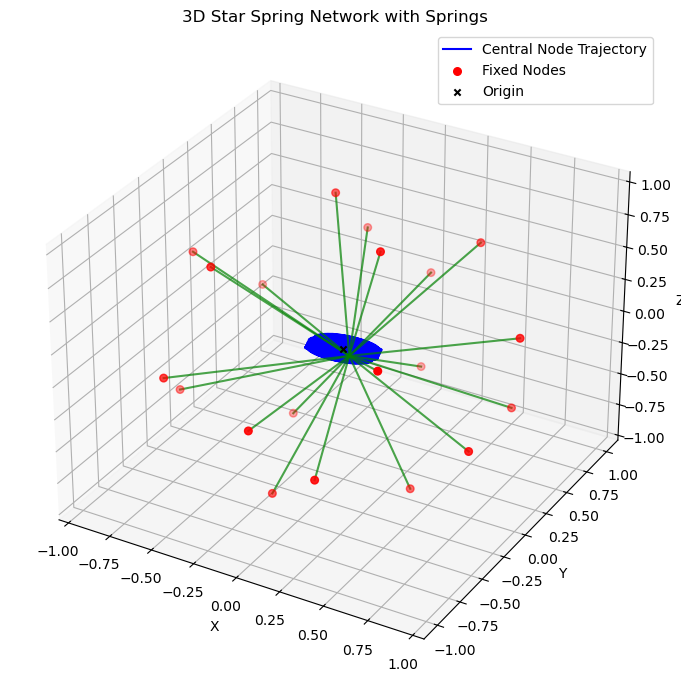

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
k = 10.0       # spring constant
m = 1.0        # mass of central node
L0 = 1.0       # rest length
N = 20         # number of outer nodes (fixed)
dim = 3        # 3D space

# Generate points on a sphere using Fibonacci sphere algorithm
def fibonacci_sphere(samples=N):
    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y from 1 to -1
        radius = np.sqrt(1 - y * y)
        theta = phi * i
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        points.append([x, y, z])
    return np.array(points)

outer_positions = fibonacci_sphere(N) * L0

# Compute total spring force on central node
def spring_force(center_pos):
    force = np.zeros(3)
    for fixed in outer_positions:
        r = center_pos - fixed
        dist = np.linalg.norm(r)
        if dist == 0:
            continue
        direction = r / dist
        force += -k * (dist - L0) * direction
    return force

# ODE system: position and velocity of central node
def ode(t, state):
    pos = state[:3]
    vel = state[3:]
    acc = spring_force(pos) / m
    return np.concatenate((vel, acc))

# Initial conditions
initial_pos = np.array([0.2, 0.0, 0.0])
initial_vel = np.array([0.0, 0.0, 0.0])
state0 = np.concatenate((initial_pos, initial_vel))

# Time span for integration
t_span = (0, 20)
t_eval = np.linspace(*t_span, 2000)

# Solve ODE
sol = solve_ivp(ode, t_span, state0, t_eval=t_eval)

# Extract central node trajectory
x, y, z = sol.y[0], sol.y[1], sol.y[2]

# Plotting
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory of the central node
ax.plot(x, y, z, label='Central Node Trajectory', color='blue')

# Plot fixed outer nodes
ax.scatter(*outer_positions.T, color='red', s=30, label='Fixed Nodes')

# Plot origin marker
ax.scatter(0, 0, 0, color='black', marker='x', label='Origin')

# Draw springs as lines from central node final position to each fixed node
central_pos_final = sol.y[:3, -1]

for fixed_node in outer_positions:
    xs = [central_pos_final[0], fixed_node[0]]
    ys = [central_pos_final[1], fixed_node[1]]
    zs = [central_pos_final[2], fixed_node[2]]
    ax.plot(xs, ys, zs, color='green', alpha=0.7)

# Labeling
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Star Spring Network with Springs')
ax.legend()
plt.tight_layout()
plt.show()


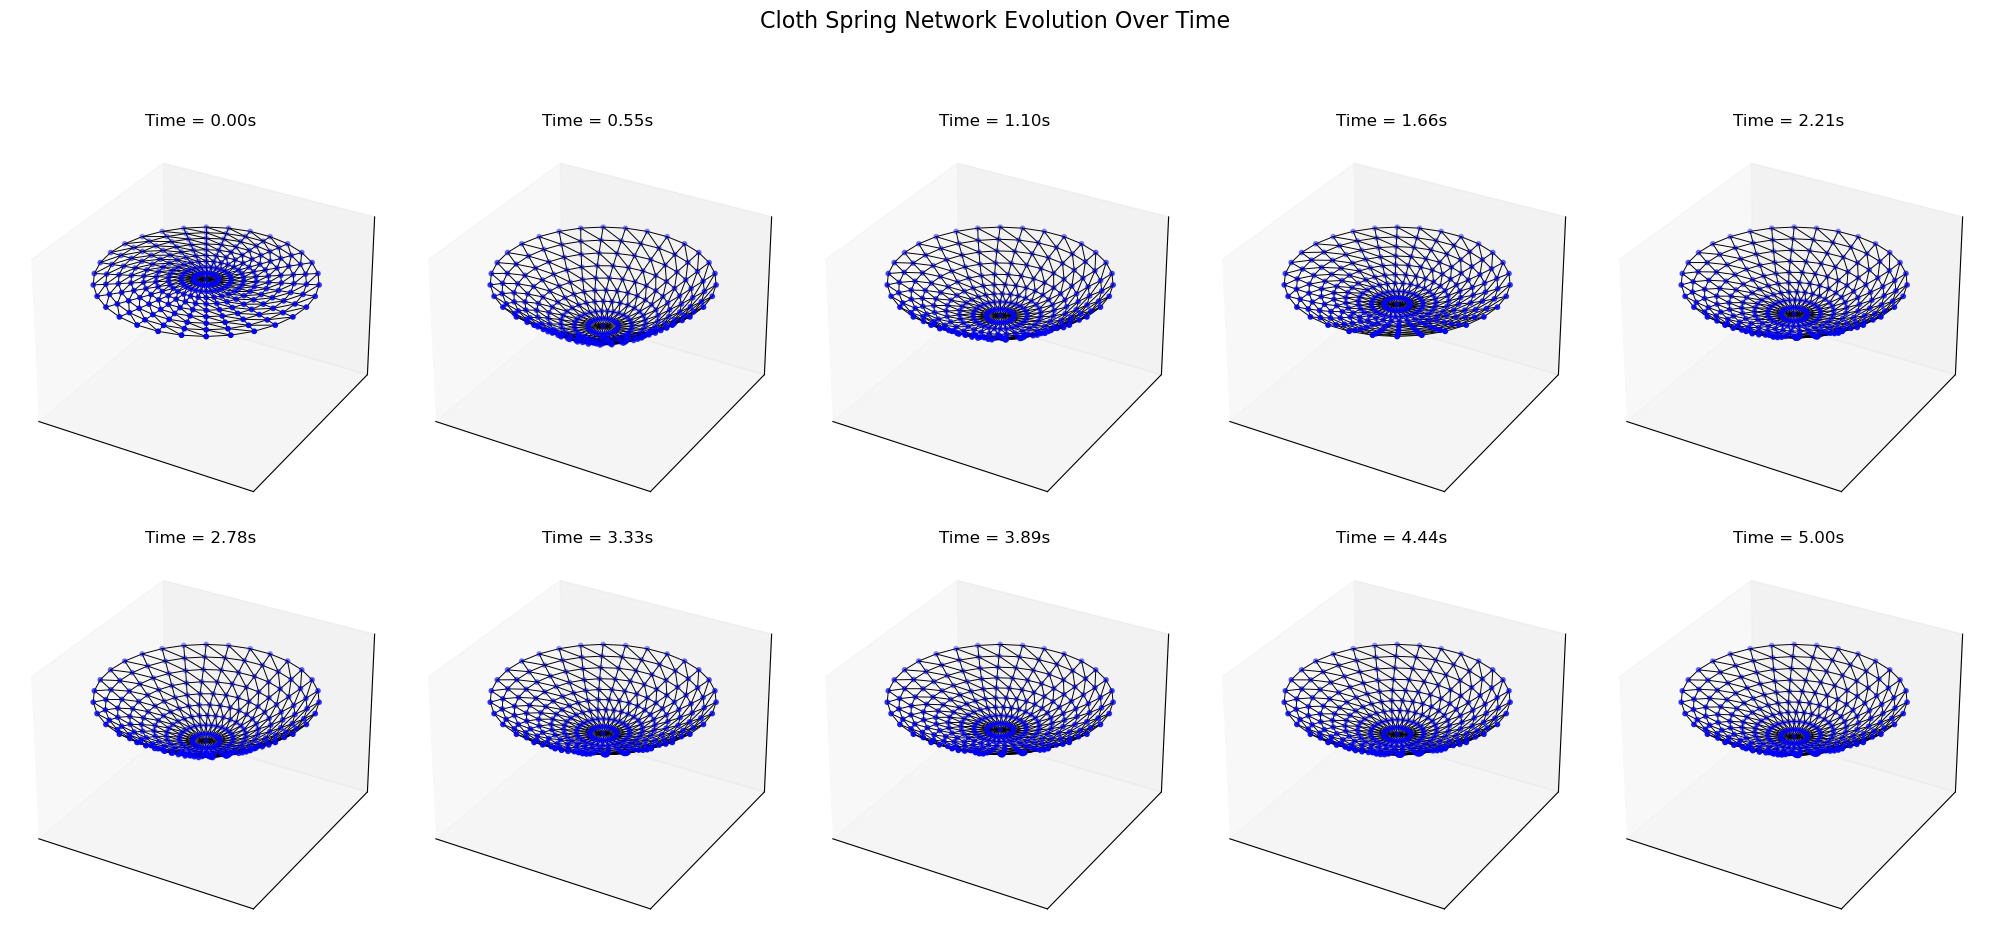

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Cloth parameters
radius = 1.0
num_rings = 10        # number of concentric rings (including center)
points_per_ring = 30  # points on each ring
k = 500.0             # spring constant
m = 0.1               # mass per node
damping = 0.1         # simple damping factor
gravity = np.array([0, 0, -9.81])  # gravity force

# Generate nodes in circular pattern (rings of points)
nodes = []
nodes.append(np.array([0, 0, 0]))  # center point

for r in range(1, num_rings):
    radius_r = radius * r / (num_rings - 1)
    for i in range(points_per_ring):
        angle = 2 * np.pi * i / points_per_ring
        x = radius_r * np.cos(angle)
        y = radius_r * np.sin(angle)
        nodes.append(np.array([x, y, 0]))

nodes = np.array(nodes)
N = len(nodes)

# Helper: find neighbors based on ring and point indices
def get_neighbors(idx):
    # center node neighbors: first ring points
    if idx == 0:
        return list(range(1, points_per_ring + 1))
    
    # ring index of node:
    # node 0: center
    # nodes 1 to points_per_ring: ring 1
    # nodes points_per_ring+1 to ... ring 2, etc.
    ring_idx = None
    count = 1
    for r in range(1, num_rings):
        if idx < count + points_per_ring:
            ring_idx = r
            break
        count += points_per_ring

    pos_in_ring = idx - (1 + (ring_idx - 1) * points_per_ring)

    neighbors = []
    # same ring neighbors (circular)
    neighbors.append(1 + (ring_idx - 1) * points_per_ring + (pos_in_ring - 1) % points_per_ring)
    neighbors.append(1 + (ring_idx - 1) * points_per_ring + (pos_in_ring + 1) % points_per_ring)

    # inner ring neighbors
    if ring_idx > 1:
        # connect to 2 closest points on inner ring (approx)
        inner_ring_start = 1 + (ring_idx - 2) * points_per_ring
        inner_pos = int(pos_in_ring * points_per_ring / points_per_ring)  # same index approx
        neighbors.append(inner_ring_start + inner_pos % points_per_ring)
        neighbors.append(inner_ring_start + (inner_pos - 1) % points_per_ring)
    else:
        # connect center node if on first ring
        neighbors.append(0)
    
    # outer ring neighbors (if not last ring)
    if ring_idx < num_rings - 1:
        outer_ring_start = 1 + ring_idx * points_per_ring
        neighbors.append(outer_ring_start + pos_in_ring % points_per_ring)
        neighbors.append(outer_ring_start + (pos_in_ring + 1) % points_per_ring)

    # unique and valid neighbors only
    neighbors = list(set(n for n in neighbors if 0 <= n < N))
    return neighbors

# Build spring rest lengths for all connections
edges = []
rest_lengths = []
for i in range(N):
    for j in get_neighbors(i):
        if i < j:
            edges.append((i, j))
            dist = np.linalg.norm(nodes[i] - nodes[j])
            rest_lengths.append(dist)
rest_lengths = np.array(rest_lengths)

# Mass and state initialization
masses = np.full(N, m)
fixed_indices = []  # indices of fixed nodes (e.g. outer ring to hold cloth)
# Let's fix all outer ring points
for i in range(1 + (num_rings - 2) * points_per_ring, N):
    fixed_indices.append(i)

# State vector: [x0,y0,z0, x1,y1,z1, ..., vx0,vy0,vz0, vx1,vy1,vz1, ...]
state0 = np.concatenate((nodes.flatten(), np.zeros(3 * N)))

def compute_forces(positions, velocities):
    forces = np.zeros_like(positions)
    # Gravity
    for i in range(N):
        forces[3*i:3*i+3] += masses[i] * gravity

    # Springs
    for idx, (i, j) in enumerate(edges):
        pos_i = positions[3*i:3*i+3]
        pos_j = positions[3*j:3*j+3]
        delta = pos_i - pos_j
        dist = np.linalg.norm(delta)
        if dist == 0:
            continue
        direction = delta / dist
        force_magnitude = -k * (dist - rest_lengths[idx])
        force = force_magnitude * direction
        forces[3*i:3*i+3] += force
        forces[3*j:3*j+3] -= force

    # Damping (simple velocity damping)
    for i in range(N):
        vel = velocities[3*i:3*i+3]
        forces[3*i:3*i+3] -= damping * vel

    # Fix nodes forces to zero (fixed nodes don't move)
    for idx in fixed_indices:
        forces[3*idx:3*idx+3] = 0

    return forces

def ode(t, state):
    positions = state[:3*N]
    velocities = state[3*N:]
    forces = compute_forces(positions, velocities)
    accelerations = forces / np.repeat(masses, 3)
    derivatives = np.zeros_like(state)
    derivatives[:3*N] = velocities
    derivatives[3*N:] = accelerations
    # zero velocity derivatives for fixed nodes
    for idx in fixed_indices:
        derivatives[3*idx:3*idx+3] = 0
        derivatives[3*N+3*idx:3*N+3*idx+3] = 0
    return derivatives

# Solve dynamics
t_span = (0, 5)
t_eval = np.linspace(*t_span, 500)
sol = solve_ivp(ode, t_span, state0, t_eval=t_eval, method='RK45')

import matplotlib.pyplot as plt

# Number of frames to plot
num_plots = 10
indices = np.linspace(0, sol.y.shape[1]-1, num_plots).astype(int)

fig = plt.figure(figsize=(20, 10))
for k, idx in enumerate(indices):
    ax = fig.add_subplot(2, 5, k+1, projection='3d')
    positions = sol.y[:3*N, idx].reshape((N, 3))
    
    ax.scatter(positions[:,0], positions[:,1], positions[:,2], c='blue', s=10)
    for i, j in edges:
        p1 = positions[i]
        p2 = positions[j]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'k-', lw=0.7)
    
    ax.set_title(f'Time = {sol.t[idx]:.2f}s')
    ax.set_xlim(-radius*1.1, radius*1.1)
    ax.set_ylim(-radius*1.1, radius*1.1)
    ax.set_zlim(-radius*1.5, radius*0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.suptitle('Cloth Spring Network Evolution Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


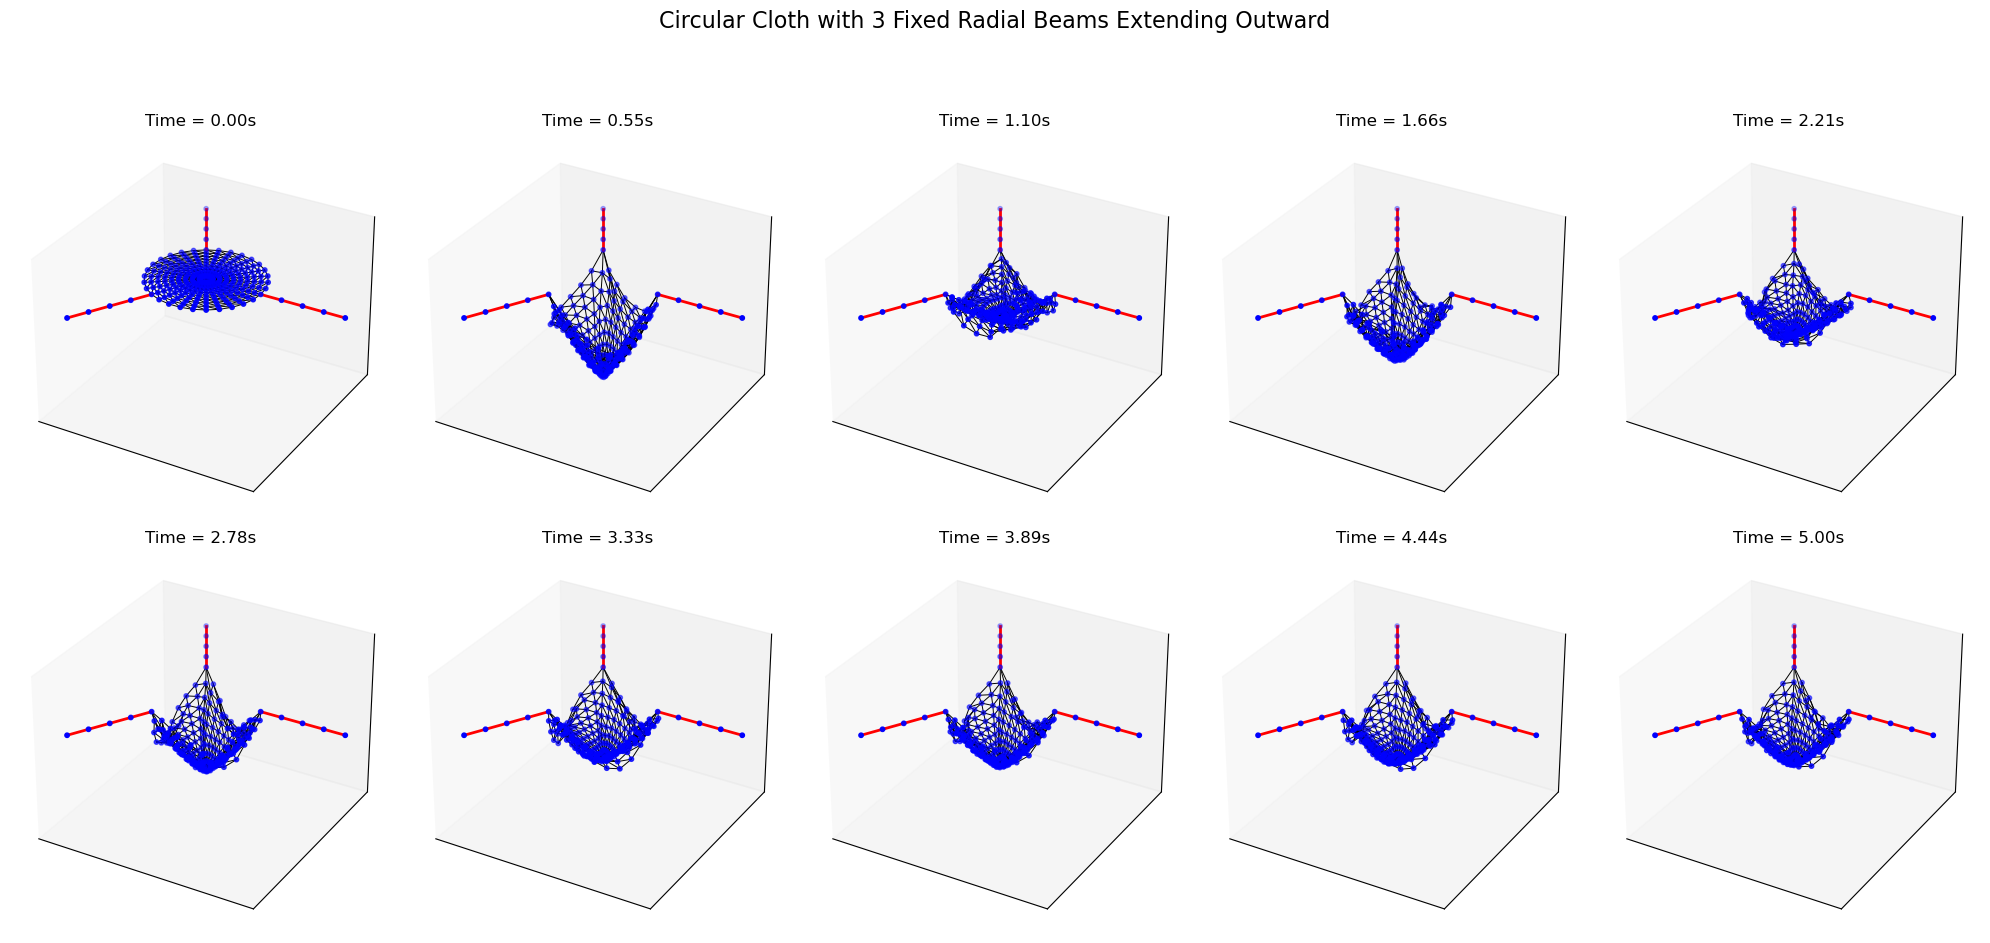

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Cloth parameters
radius = 1.0
num_rings = 10        # number of concentric rings (including center)
points_per_ring = 30  # points on each ring
k = 500.0             # spring constant
m = 0.1               # mass per node
damping = 0.1         # simple damping factor
gravity = np.array([0, 0, -9.81])  # gravity force

# Generate nodes in circular pattern (rings of points)
nodes = []
nodes.append(np.array([0, 0, 0]))  # center point

for r in range(1, num_rings):
    radius_r = radius * r / (num_rings - 1)
    for i in range(points_per_ring):
        angle = 2 * np.pi * i / points_per_ring
        x = radius_r * np.cos(angle)
        y = radius_r * np.sin(angle)
        nodes.append(np.array([x, y, 0]))

nodes = np.array(nodes)
N = len(nodes)

# Helper: find neighbors based on ring and point indices
def get_neighbors(idx):
    if idx == 0:
        return list(range(1, points_per_ring + 1))
    
    ring_idx = None
    count = 1
    for r in range(1, num_rings):
        if idx < count + points_per_ring:
            ring_idx = r
            break
        count += points_per_ring

    pos_in_ring = idx - (1 + (ring_idx - 1) * points_per_ring)

    neighbors = []
    # same ring neighbors (circular)
    neighbors.append(1 + (ring_idx - 1) * points_per_ring + (pos_in_ring - 1) % points_per_ring)
    neighbors.append(1 + (ring_idx - 1) * points_per_ring + (pos_in_ring + 1) % points_per_ring)

    # inner ring neighbors
    if ring_idx > 1:
        inner_ring_start = 1 + (ring_idx - 2) * points_per_ring
        inner_pos = int(pos_in_ring * points_per_ring / points_per_ring)
        neighbors.append(inner_ring_start + inner_pos % points_per_ring)
        neighbors.append(inner_ring_start + (inner_pos - 1) % points_per_ring)
    else:
        neighbors.append(0)
    
    # outer ring neighbors (if not last ring)
    if ring_idx < num_rings - 1:
        outer_ring_start = 1 + ring_idx * points_per_ring
        neighbors.append(outer_ring_start + pos_in_ring % points_per_ring)
        neighbors.append(outer_ring_start + (pos_in_ring + 1) % points_per_ring)

    neighbors = list(set(n for n in neighbors if 0 <= n < N))
    return neighbors

# Build spring rest lengths for all connections in cloth
edges = []
rest_lengths = []
for i in range(N):
    for j in get_neighbors(i):
        if i < j:
            edges.append((i, j))
            dist = np.linalg.norm(nodes[i] - nodes[j])
            rest_lengths.append(dist)
rest_lengths = np.array(rest_lengths)

# Now add radial beams (springs) extending outward from outer ring points
num_beams = 3
beam_length = 1.5  # length of each beam beyond outer ring radius
beam_nodes_per_beam = 5  # nodes per beam, including the one on outer ring

beam_angles = np.linspace(0, 2*np.pi, num_beams, endpoint=False)

beam_nodes = []
beam_edges = []

for angle in beam_angles:
    # Find the closest node on the outer ring at this angle
    outer_ring_start = 1 + (num_rings - 2) * points_per_ring
    outer_ring_end = outer_ring_start + points_per_ring
    outer_ring_nodes = nodes[outer_ring_start:outer_ring_end]

    target_pos = np.array([radius * np.cos(angle), radius * np.sin(angle), 0])
    dists = np.linalg.norm(outer_ring_nodes - target_pos, axis=1)
    closest_idx = np.argmin(dists) + outer_ring_start

    # This node is the first node of the beam
    prev_idx = closest_idx
    beam_nodes.append(prev_idx)  # keep track to fix later

    # Generate beam nodes extending radially outward from the circle
    for i in range(1, beam_nodes_per_beam):
        dist_out = radius + i * beam_length / (beam_nodes_per_beam - 1)
        x = dist_out * np.cos(angle)
        y = dist_out * np.sin(angle)
        z = 0.0
        new_node = np.array([x, y, z])
        beam_nodes.append(N)  # index of new node will be N currently
        nodes = np.vstack([nodes, new_node])
        # Connect new node with previous node by spring
        beam_edges.append((prev_idx, N))
        prev_idx = N
        N += 1

# Add beam edges to edges list
edges.extend(beam_edges)

# Calculate rest lengths for new beam edges
for (i, j) in beam_edges:
    dist = np.linalg.norm(nodes[i] - nodes[j])
    rest_lengths = np.append(rest_lengths, dist)

# Mass and state initialization
masses = np.full(N, m)

# Fix nodes on the beams (including outer ring nodes connected to beams)
fixed_indices = list(set(beam_nodes))

# State vector: positions and velocities
state0 = np.concatenate((nodes.flatten(), np.zeros(3 * N)))

def compute_forces(positions, velocities):
    forces = np.zeros_like(positions)
    # Gravity
    for i in range(N):
        forces[3*i:3*i+3] += masses[i] * gravity

    # Springs
    for idx, (i, j) in enumerate(edges):
        pos_i = positions[3*i:3*i+3]
        pos_j = positions[3*j:3*j+3]
        delta = pos_i - pos_j
        dist = np.linalg.norm(delta)
        if dist == 0:
            continue
        direction = delta / dist
        force_magnitude = -k * (dist - rest_lengths[idx])
        force = force_magnitude * direction
        forces[3*i:3*i+3] += force
        forces[3*j:3*j+3] -= force

    # Damping
    for i in range(N):
        vel = velocities[3*i:3*i+3]
        forces[3*i:3*i+3] -= damping * vel

    # Fix nodes
    for idx in fixed_indices:
        forces[3*idx:3*idx+3] = 0

    return forces

def ode(t, state):
    positions = state[:3*N]
    velocities = state[3*N:]
    forces = compute_forces(positions, velocities)
    accelerations = forces / np.repeat(masses, 3)
    derivatives = np.zeros_like(state)
    derivatives[:3*N] = velocities
    derivatives[3*N:] = accelerations

    # Zero velocity and acceleration for fixed nodes
    for idx in fixed_indices:
        derivatives[3*idx:3*idx+3] = 0
        derivatives[3*N+3*idx:3*N+3*idx+3] = 0

    return derivatives

# Solve dynamics
t_span = (0, 5)
t_eval = np.linspace(*t_span, 500)
sol = solve_ivp(ode, t_span, state0, t_eval=t_eval, method='RK45')

# Plot snapshots
num_plots = 10
indices = np.linspace(0, sol.y.shape[1]-1, num_plots).astype(int)

fig = plt.figure(figsize=(20, 10))
for k, idx in enumerate(indices):
    ax = fig.add_subplot(2, 5, k+1, projection='3d')
    positions = sol.y[:3*N, idx].reshape((N, 3))

    ax.scatter(positions[:,0], positions[:,1], positions[:,2], c='blue', s=10)

    # Draw cloth edges (exclude beams)
    cloth_edge_set = set(edges) - set(beam_edges)
    for i, j in cloth_edge_set:
        p1 = positions[i]
        p2 = positions[j]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'k-', lw=0.7)

    # Draw beams in red
    for i, j in beam_edges:
        p1 = positions[i]
        p2 = positions[j]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'r-', lw=2)

    ax.set_title(f'Time = {sol.t[idx]:.2f}s')
    ax.set_xlim(-radius*2, radius*2)
    ax.set_ylim(-radius*2, radius*2)
    ax.set_zlim(-radius*1.5, radius*0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.suptitle('Circular Cloth with 3 Fixed Radial Beams Extending Outward', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [20]:
class CircularClothWithBeams:
    def __init__(self,
                 radius=1.0,
                 num_rings=10,
                 points_per_ring=30,
                 k=500.0,
                 m=0.1,
                 damping=0.1,
                 gravity=np.array([0, 0, -9.81]),
                 num_beams=3,
                 beam_length=1.5,
                 beam_nodes_per_beam=1):
        
        self.radius = radius
        self.num_rings = num_rings
        self.points_per_ring = points_per_ring
        self.k = k
        self.m = m
        self.damping = damping
        self.gravity = gravity
        
        self.num_beams = num_beams
        self.beam_length = beam_length
        self.beam_nodes_per_beam = beam_nodes_per_beam
        
        self.nodes = None
        self.N = 0
        self.edges = []
        self.rest_lengths = None
        self.masses = None
        self.fixed_indices = []
        self.beam_edges = []
        self.state0 = None
        
        self._generate_nodes()
        self._generate_edges_and_rest_lengths()
        self._add_beams()
        self._finalize_state()
        
    def _generate_nodes(self):
        nodes = []
        nodes.append(np.array([0, 0, 0]))  # center point
        for r in range(1, self.num_rings):
            radius_r = self.radius * r / (self.num_rings - 1)
            for i in range(self.points_per_ring):
                angle = 2 * np.pi * i / self.points_per_ring
                x = radius_r * np.cos(angle)
                y = radius_r * np.sin(angle)
                nodes.append(np.array([x, y, 0]))
        self.nodes = np.array(nodes)
        self.N = len(self.nodes)
        
    def _get_neighbors(self, idx):
        if idx == 0:
            return list(range(1, self.points_per_ring + 1))
        
        ring_idx = None
        count = 1
        for r in range(1, self.num_rings):
            if idx < count + self.points_per_ring:
                ring_idx = r
                break
            count += self.points_per_ring

        pos_in_ring = idx - (1 + (ring_idx - 1) * self.points_per_ring)

        neighbors = []
        neighbors.append(1 + (ring_idx - 1) * self.points_per_ring + (pos_in_ring - 1) % self.points_per_ring)
        neighbors.append(1 + (ring_idx - 1) * self.points_per_ring + (pos_in_ring + 1) % self.points_per_ring)

        if ring_idx > 1:
            inner_ring_start = 1 + (ring_idx - 2) * self.points_per_ring
            inner_pos = int(pos_in_ring * self.points_per_ring / self.points_per_ring)
            neighbors.append(inner_ring_start + inner_pos % self.points_per_ring)
            neighbors.append(inner_ring_start + (inner_pos - 1) % self.points_per_ring)
        else:
            neighbors.append(0)
        
        if ring_idx < self.num_rings - 1:
            outer_ring_start = 1 + ring_idx * self.points_per_ring
            neighbors.append(outer_ring_start + pos_in_ring % self.points_per_ring)
            neighbors.append(outer_ring_start + (pos_in_ring + 1) % self.points_per_ring)

        neighbors = list(set(n for n in neighbors if 0 <= n < self.N))
        return neighbors
    
    def _generate_edges_and_rest_lengths(self):
        edges = []
        rest_lengths = []
        for i in range(self.N):
            for j in self._get_neighbors(i):
                if i < j:
                    edges.append((i, j))
                    dist = np.linalg.norm(self.nodes[i] - self.nodes[j])
                    rest_lengths.append(dist)
        self.edges = edges
        self.rest_lengths = np.array(rest_lengths)
    
    def _add_beams(self):
        beam_nodes = []
        beam_edges = []

        beam_angles = np.linspace(0, 2*np.pi, self.num_beams, endpoint=False)
        outer_ring_start = 1 + (self.num_rings - 2) * self.points_per_ring
        outer_ring_end = outer_ring_start + self.points_per_ring

        for angle in beam_angles:
            outer_ring_nodes = self.nodes[outer_ring_start:outer_ring_end]
            target_pos = np.array([self.radius * np.cos(angle), self.radius * np.sin(angle), 0])
            dists = np.linalg.norm(outer_ring_nodes - target_pos, axis=1)
            closest_idx = np.argmin(dists) + outer_ring_start

            prev_idx = closest_idx
            beam_nodes.append(prev_idx)  # fixed outer ring node connected to beam

            for i in range(1, self.beam_nodes_per_beam):
                dist_out = self.radius + i * self.beam_length / (self.beam_nodes_per_beam - 1)
                x = dist_out * np.cos(angle)
                y = dist_out * np.sin(angle)
                z = 0.0
                new_node = np.array([x, y, z])
                self.nodes = np.vstack([self.nodes, new_node])
                new_idx = self.N
                beam_nodes.append(new_idx)
                beam_edges.append((prev_idx, new_idx))
                prev_idx = new_idx
                self.N += 1

        self.beam_edges = beam_edges
        self.edges.extend(beam_edges)

        for (i, j) in beam_edges:
            dist = np.linalg.norm(self.nodes[i] - self.nodes[j])
            self.rest_lengths = np.append(self.rest_lengths, dist)

        self.fixed_indices = list(set(beam_nodes))
    
    def _finalize_state(self):
        self.masses = np.full(self.N, self.m)
        self.state0 = np.concatenate((self.nodes.flatten(), np.zeros(3 * self.N)))
    
    def compute_forces(self, positions, velocities):
        forces = np.zeros_like(positions)
        for i in range(self.N):
            forces[3*i:3*i+3] += self.masses[i] * self.gravity
        
        for idx, (i, j) in enumerate(self.edges):
            pos_i = positions[3*i:3*i+3]
            pos_j = positions[3*j:3*j+3]
            delta = pos_i - pos_j
            dist = np.linalg.norm(delta)
            if dist == 0:
                continue
            direction = delta / dist
            force_magnitude = -self.k * (dist - self.rest_lengths[idx])
            force = force_magnitude * direction
            forces[3*i:3*i+3] += force
            forces[3*j:3*j+3] -= force
        
        for i in range(self.N):
            vel = velocities[3*i:3*i+3]
            forces[3*i:3*i+3] -= self.damping * vel
        
        for idx in self.fixed_indices:
            forces[3*idx:3*idx+3] = 0
        
        return forces
    
    def ode(self, t, state):
        positions = state[:3*self.N]
        velocities = state[3*self.N:]
        forces = self.compute_forces(positions, velocities)
        accelerations = forces / np.repeat(self.masses, 3)
        
        derivatives = np.zeros_like(state)
        derivatives[:3*self.N] = velocities
        derivatives[3*self.N:] = accelerations
        
        for idx in self.fixed_indices:
            derivatives[3*idx:3*idx+3] = 0
            derivatives[3*self.N + 3*idx:3*self.N + 3*idx+3] = 0
        
        return derivatives


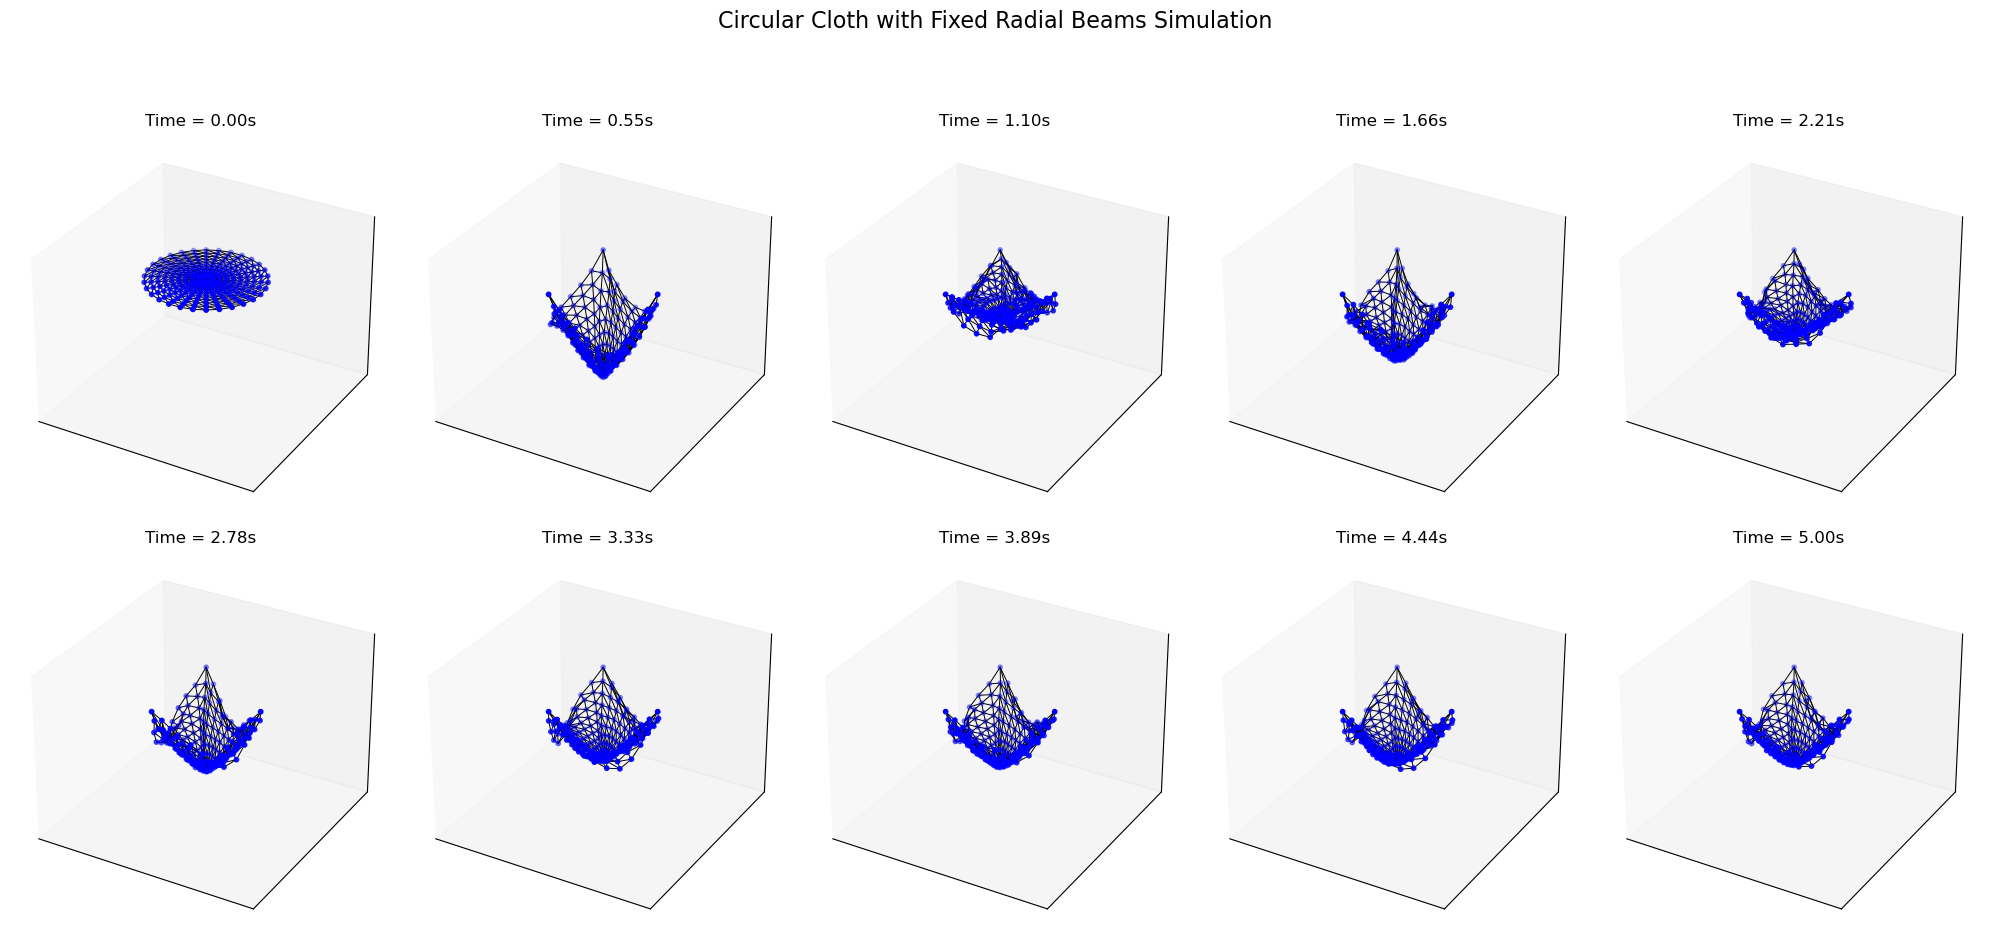

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

# Assuming CircularClothWithBeams class is already defined above...

# Create instance of the system
cloth = CircularClothWithBeams()

# Time span and evaluation points
t_span = (0, 5)
t_eval = np.linspace(*t_span, 500)

# Run the simulation
sol = solve_ivp(cloth.ode, t_span, cloth.state0, t_eval=t_eval, method='RK45')

# Plot snapshots
num_plots = 10
indices = np.linspace(0, sol.y.shape[1]-1, num_plots).astype(int)

fig = plt.figure(figsize=(20, 10))
for k, idx in enumerate(indices):
    ax = fig.add_subplot(2, 5, k+1, projection='3d')
    positions = sol.y[:3*cloth.N, idx].reshape((cloth.N, 3))

    ax.scatter(positions[:,0], positions[:,1], positions[:,2], c='blue', s=10)

    # Draw cloth edges (exclude beams)
    cloth_edge_set = set(cloth.edges) - set(cloth.beam_edges)
    for i, j in cloth_edge_set:
        p1 = positions[i]
        p2 = positions[j]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'k-', lw=0.7)

    # Draw beams in red
    for i, j in cloth.beam_edges:
        p1 = positions[i]
        p2 = positions[j]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'r-', lw=2)

    ax.set_title(f'Time = {sol.t[idx]:.2f}s')
    ax.set_xlim(-cloth.radius*2, cloth.radius*2)
    ax.set_ylim(-cloth.radius*2, cloth.radius*2)
    ax.set_zlim(-cloth.radius*1.5, cloth.radius*0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.suptitle('Circular Cloth with Fixed Radial Beams Simulation', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
